There are two approaches to train a GNN on the EEG signal:


1.   Many Feature Nodes:
  *   Signal itself
  *   AR model coeffs

  and the edge feature is distance of the electrodes

2.   Trained Edge Features:
  *   Distance electrodes
  *   Distance opt AR

  and the node feature is the degree  of each node

In [ ]:
!pip install torch_geometric

In [ ]:
from scipy.io import loadmat
import numpy as np
path = '/content/drive/MyDrive/Ex3.mat'
data = loadmat(path)
path = '/content/drive/MyDrive/distance_electrodes.mat'
dist = loadmat(path)
path = '/content/drive/MyDrive/graphs.mat'
weights = loadmat(path)
path = '/content/drive/MyDrive/ar.mat'
ar = loadmat(path)
ar = ar['data_ar_coeff']

In [ ]:
print(ar.shape)

(30, 21, 165)


In [ ]:
weights = weights['Ws']
print(weights.shape)

(165, 30, 30)


In [ ]:
TrainData = data['TrainData']
TrainLabel = data['TrainLabel']
print(TrainData.shape)
print(TrainLabel.shape)
dist = dist['dist']
print(dist.shape)

(30, 256, 165)
(1, 165)
(30, 30)


In [ ]:
import networkx as nx
import torch_geometric
from torch_geometric.utils.convert import from_networkx
from torch_geometric.loader import DataLoader

In [ ]:
data_list = []
for k in range(165):
  G = nx.Graph(y=TrainLabel[0, k])
  node_attrs = {}
  for i in range(30):
    feats_node = {}
    #feats_node['x'] = TrainData[i, :, k]
    feats_node['x'] = ar[i, :, k]
    G.add_node(i)
    node_attrs[i] = feats_node
  nx.set_node_attributes(G, node_attrs)
  edge_attrs = {}
  for i in range(30):
    for j in range(30):
      #G.add_edge(i, j, weight=dist[i, j])
      G.add_edge(i, j, weight=weights[k, i, j])
  pyg_graph = from_networkx(G)
  data_list.append(pyg_graph)

In [ ]:
train_datalist = data_list[:132]
test_datalist = data_list[132:]
print(f'Number of training graphs: {len(train_datalist)}')
print(f'Number of test graphs: {len(test_datalist)}')

Number of training graphs: 132
Number of test graphs: 33


In [ ]:
train_loader = DataLoader(train_datalist, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_datalist, batch_size = 32, shuffle=False)
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[960, 256], edge_index=[2, 28800], y=[32], weight=[28800], batch=[960], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(x=[960, 256], edge_index=[2, 28800], y=[32], weight=[28800], batch=[960], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(x=[960, 256], edge_index=[2, 28800], y=[32], weight=[28800], batch=[960], ptr=[33])

Step 4:
Number of graphs in the current batch: 32
DataBatch(x=[960, 256], edge_index=[2, 28800], y=[32], weight=[28800], batch=[960], ptr=[33])

Step 5:
Number of graphs in the current batch: 4
DataBatch(x=[120, 256], edge_index=[2, 3600], y=[4], weight=[3600], batch=[120], ptr=[5])



In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(21, hidden_channels, improved = True)
        self.conv2 = GCNConv(hidden_channels, hidden_channels//2, improved = True)
        self.conv3 = GCNConv(hidden_channels//2, hidden_channels//4, improved = True)
        self.lin = Linear(hidden_channels//4, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=15)
print(model)

GCN(
  (conv1): GCNConv(21, 15)
  (conv2): GCNConv(15, 7)
  (conv3): GCNConv(7, 3)
  (lin): Linear(in_features=3, out_features=2, bias=True)
)


In [ ]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def pltconf(y_actucal, y_pred, title):
  conf_matrix = confusion_matrix(y_actucal, y_pred)
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title(title, fontsize=18)
  t1 = 'Accuracy: %.3f' % accuracy_score(y_actucal, y_pred)
  t2 = ' ,Precision: %.3f' % precision_score(y_actucal, y_pred)
  t3 = ' ,Recall: %.3f' % recall_score(y_actucal, y_pred)
  t4 = ' ,F1 Score: %.3f' % f1_score(y_actucal, y_pred)
  fig.text(.5, .0001, t1+t2+t3+t4, ha='center')
  plt.show()
  return(accuracy_score(y_actucal, y_pred))

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
train_ind = []
test_ind = []
for train_index, test_index in kf.split(data_list):
  train_ind.append(train_index)
  test_ind.append(test_index)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


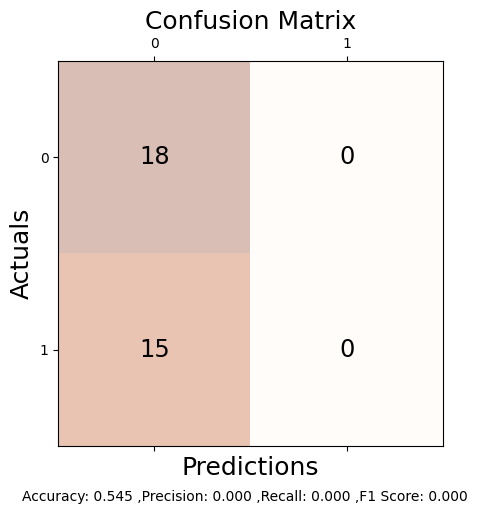

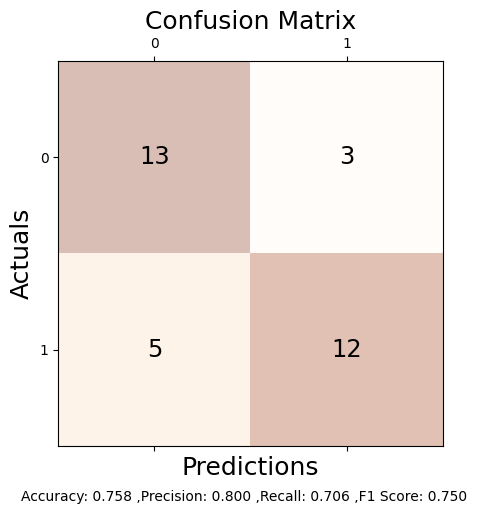

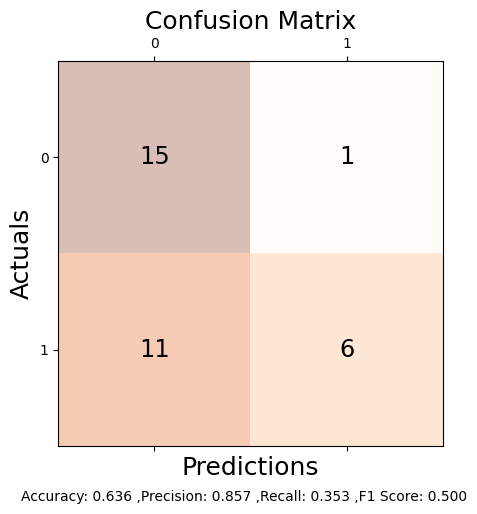

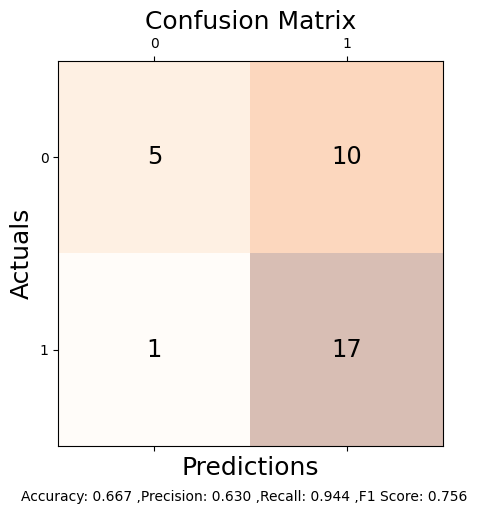

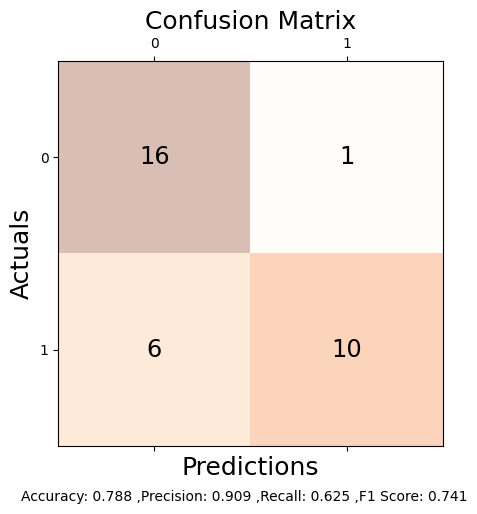

0.6787878787878787
0.0869860611782262


In [ ]:
fold = 0
acccc = []
for k in range(5):
  fold = k
  train_datalist = [data_list[index] for index in train_ind[fold]]
  test_datalist = [data_list[index] for index in test_ind[fold]]
  train_loader = DataLoader(train_datalist, batch_size = 10, shuffle=True)
  test_loader = DataLoader(test_datalist, batch_size = 33, shuffle=False)
  model = GCN(hidden_channels=15)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = torch.nn.CrossEntropyLoss()


  def train():
      model.train()

      for data in train_loader:  # Iهterate in batches over the training dataset.
          out = model(data.x.float(), data.edge_index, data.batch)  # Perform a single forward pass.
          loss = criterion(out, data.y)  # Compute the loss.
          loss.backward()  # Derive gradients.
          optimizer.step()  # Update parameters based on gradients.
          optimizer.zero_grad()  # Clear gradients.

  def test(loader):
      model.eval()

      correct = 0
      acct = []
      preds = []
      for data in loader:  # Iterate in batches over the training/test dataset.
          out = model(data.x.float(), data.edge_index, data.batch)
          pred = out.argmax(dim=1)  # Use the class with highest probability.
          acct.append(data.y)
          preds.append(pred)
          correct += int((pred == data.y).sum())  # Check against ground-truth labels.
      return correct / len(loader.dataset), acct, preds  # Derive ratio of correct predictions.

  best_acc = 0
  best_acct = []
  best_preds = []
  for epoch in range(1, 50):
      train()
      train_acc = test(train_loader)
      test_acc, acct, preds = test(test_loader)
      if test_acc > best_acc:
        best_acc = test_acc
        best_acct = acct
        best_preds = preds
      #print(f'Epoch: {epoch:03d}, Train Acc: {train_acc[0]:.4f}, Test Acc: {test_acc:.4f}')
  best_acct = best_acct[0].numpy()
  best_preds = best_preds[0].numpy()
  aa = pltconf(best_acct, best_preds, 'Confusion Matrix')
  acccc.append(aa)
  for layer in model.children():
      layer.reset_parameters()
print(np.mean(acccc))
print(np.std(acccc))


In [ ]:
print(np.array(acccc)

[None, None, None, None, None]
